# 包导入和参数设置

In [2]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import os
from PIL import Image
import torchvision.models as models
from tqdm import tqdm 
from torch.utils.data import random_split

base_path = './kaggle/input/classify-leaves'
out_path = './kaggle/working'

## 数据查看

In [3]:
train_df= pd.read_csv(os.path.join(base_path,"train.csv"))
val_df = pd.read_csv(os.path.join(base_path,"test.csv"))

# 统计每个类别的数量
label_counts = train_df['label'].value_counts()

print(train_df.shape,'\n')
print(train_df.info(),'\n')
print(train_df.describe(), "\n")
print(train_df.head(),'\n')

(18353, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18353 entries, 0 to 18352
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18353 non-null  object
 1   label   18353 non-null  object
dtypes: object(2)
memory usage: 286.9+ KB
None 

               image             label
count          18353             18353
unique         18353               176
top     images/0.jpg  maclura_pomifera
freq               1               353 

          image             label
0  images/0.jpg  maclura_pomifera
1  images/1.jpg  maclura_pomifera
2  images/2.jpg  maclura_pomifera
3  images/3.jpg  maclura_pomifera
4  images/4.jpg  maclura_pomifera 



## 饼状图

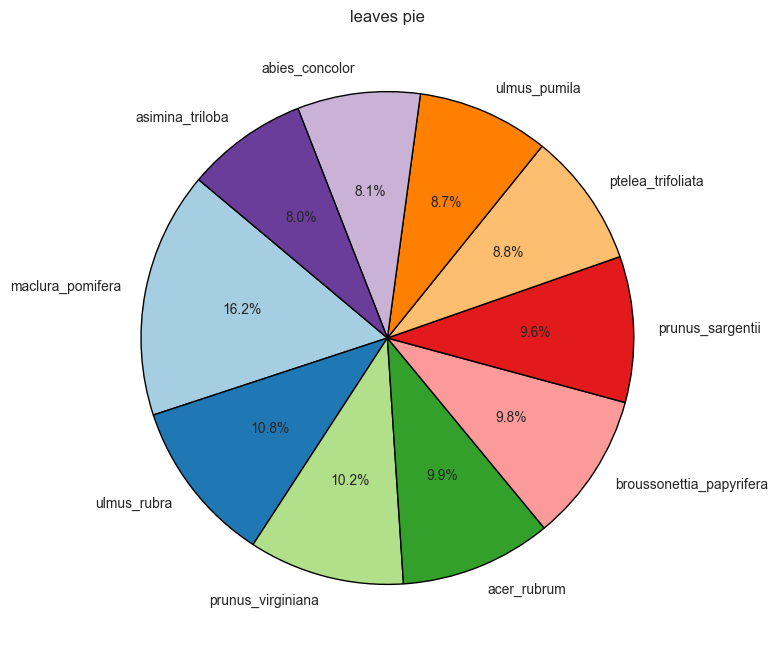

In [4]:
plt.figure(figsize=(8, 8)) 
plt.pie(
    label_counts.values[:10], 
    labels=label_counts.index[:10], 
    autopct='%1.1f%%',  # 显示百分比
    colors=plt.cm.Paired.colors,  # 配色
    startangle=140, 
    wedgeprops={'edgecolor': 'black'}  # 添加边框
)

# 设置标题
plt.title("leaves pie")

# 显示图像
plt.show()

## 直方图

C:\Users\万傲伟\AppData\Local\Temp\ipykernel_24584\3982459764.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index[:30], y=label_counts.values[:30], palette="viridis")  # 只画前30个类别


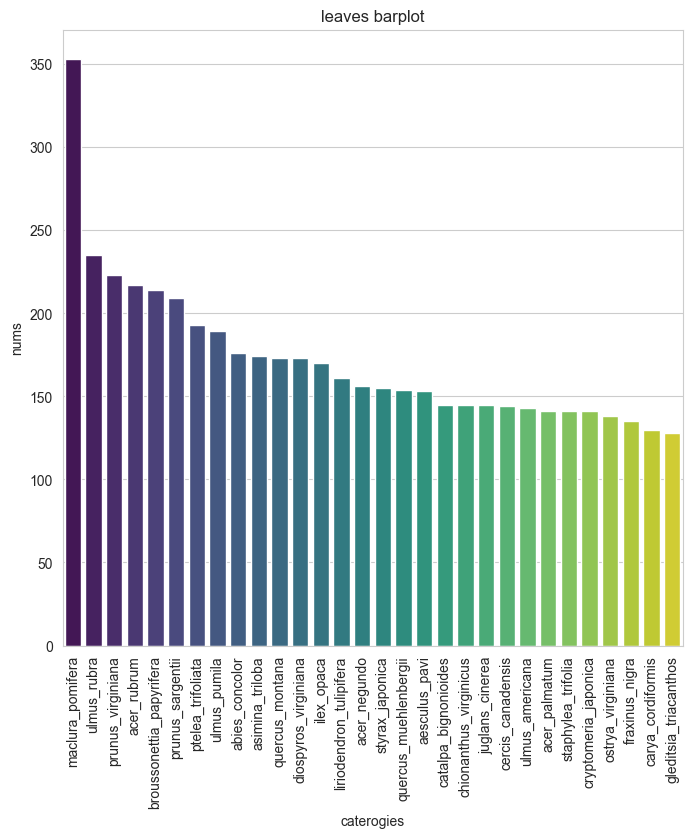

In [5]:
# 绘制直方图
plt.figure(figsize=(8, 8)) 
sns.barplot(x=label_counts.index[:30], y=label_counts.values[:30], palette="viridis")  # 只画前30个类别
plt.xticks(rotation=90)  # 旋转x轴标签，防止重叠
plt.xlabel("caterogies")
plt.ylabel("nums")
plt.title("leaves barplot")

# 显示图像
plt.show()

## 预览图片

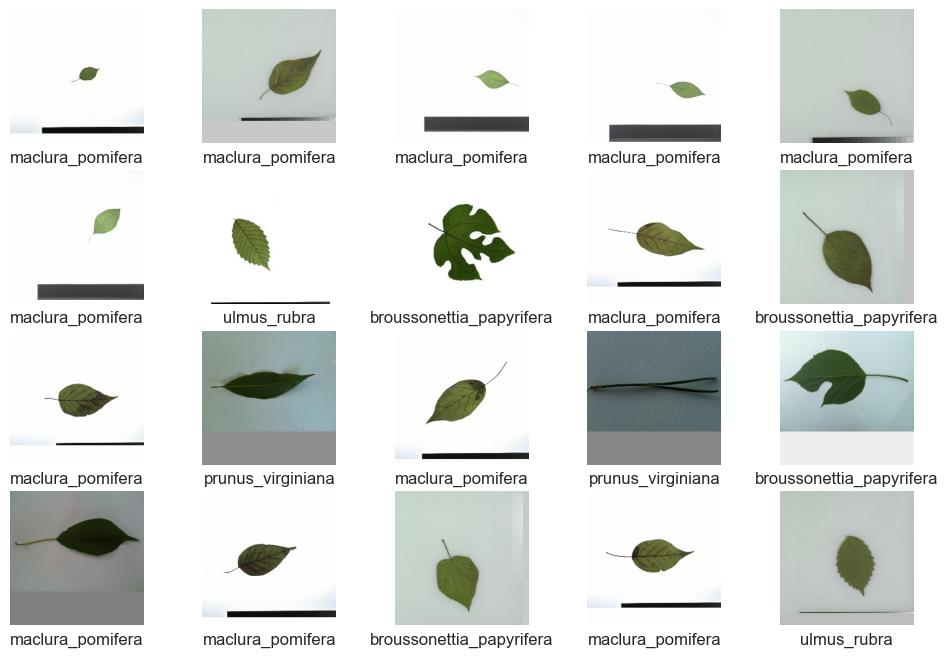

In [6]:
# 查看前20张图片
preview_image_paths = train_df['image'][:20]
preview_image_labels = train_df['label'][:20]
# 创建子图
fig, axes = plt.subplots(4,5, figsize=(12, 8))  # 一行多列

for i,(ax,img_path) in enumerate(zip(axes.flatten(),preview_image_paths)):
    img = mpimg.imread(os.path.join(base_path, img_path))  # 读取图片
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(preview_image_labels[i],y=-0.2)

plt.show()


# 准备数据

In [7]:
# 获取所有唯一的类别（叶子种类）
unique_labels = train_df["label"].unique()

# 创建 类别 → 索引 的映射
label2idx = {label: idx for idx, label in enumerate(unique_labels)}

# 创建反向映射（id → label）
idx2label = {v: k for k, v in label2idx.items()}

## 自定义dataset

In [8]:
from LeaveDataset import LeaveDataset as LeaveDataset

## 封装DataLoader

In [9]:
batch_size=128

# 定义数据转换
transform = T.Compose([
    # T.Resize((224, 224)),  # 调整图片大小
    T.ToTensor(),  # 转为张量
    # T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

train_dataset = LeaveDataset(train_df,transform)

# 计算拆分大小
total_size = len(train_dataset)
test_size = int(0.2 * total_size)  # 20% 作为测试集
train_size = total_size - test_size  # 剩下的作为训练集

# 随机拆分数据
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

# 重新创建 DataLoader
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4)

print("总批次:",len(train_loader))

总批次: 115


# 定义模型

In [10]:
# 加载 ResNet-18（可以换成 resnet34, resnet50, resnet101, resnet152）
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 修改最终输出的类别
num_classes = len(label_counts)  
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)

# 设备类型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

resnet = resnet.to(device)

resnet

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 损失函数和优化器

In [11]:
# 交叉熵损失（适用于分类问题）
criterion = nn.CrossEntropyLoss()

# 学习率，动量
lr,momentum = 0.01,0.9

# 优化器
optimizer = optim.SGD(resnet.parameters(), lr=lr, momentum=momentum)

# 训练模型

In [12]:
# 单次训练
def train():
    resnet.train()

    batch_nums = len(train_loader)  # 批次数
    batch_size = train_loader.batch_size  # 批量大小
    size = len(train_loader.dataset)  # 数据集大小
    
    train_loss,correct = 0.0, 0.0 # 统计损失和准确率

    p = tqdm(train_loader, desc="Training", unit="batch")
    
    for X,y in p:
        X,y = X.to(device),y.to(device)
        pred = resnet(X)
        loss = criterion(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        p.set_postfix(loss=f"{loss.item():>8f}")  # 显示损失值
        
        train_loss+=loss.item() # 累计每个批次的平均损失
        correct += (pred.argmax(1) == y).sum().item() # 计算正确预测的数量

    train_loss /= batch_nums
    correct /= size
    print(f"Train Accuracy: {(100*correct):>0.2f}%, Train Avg loss: {train_loss:>8f}")

    return train_loss,correct


In [13]:


# 验证
def test():
    resnet.eval() # 评估模式
    
    batch_nums = len(test_loader)  # 批次数
    batch_size = test_loader.batch_size  # 批量大小
    size = len(test_loader.dataset)  # 数据集大小
    
    test_loss,correct = 0.0, 0.0 # 统计损失和准确率

    with torch.no_grad():
        
        for X,y in test_loader:
            X,y = X.to(device),y.to(device)
            pred = resnet(X)
            loss = criterion(pred,y)

            test_loss+=loss.item() # 累计每个批次的平均损失
            correct += (pred.argmax(1) == y).sum().item() # 计算正确预测的数量

    test_loss /= batch_nums
    correct /= size
    print(f"Test Accuracy: {(100*correct):>0.1f}%, Test Avg loss: {test_loss:>8f}")
    
    return test_loss,correct
            
    

In [14]:
# 训练损失和准确率
train_losses,train_accs = [],[]

# 测试损失和准确率
test_losses ,test_accs= [],[]

epochs = 10

best_acc = 0.0  # 记录最佳准确率
save_path = 'best_model.pth'  # 保存路径

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    train_loss,train_acc = train()
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_loss,test_acc = test()
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # 保存最好的模型
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(resnet.state_dict(), save_path)  # 仅保存状态字典
        print(f'New best model saved with accuracy: {best_acc:.4f}')

    print("-"*30)
    

Epoch 1


Training: 100%|██████████| 115/115 [06:57<00:00,  3.63s/batch, loss=1.393687]


Train Accuracy: 39.41%, Train Avg loss: 2.889979
Test Accuracy: 63.7%, Test Avg loss: 1.583343
New best model saved with accuracy: 0.6371
------------------------------
Epoch 2


Training: 100%|██████████| 115/115 [06:02<00:00,  3.15s/batch, loss=0.565174]


Train Accuracy: 81.33%, Train Avg loss: 0.846095
Test Accuracy: 76.5%, Test Avg loss: 0.927734
New best model saved with accuracy: 0.7649
------------------------------
Epoch 3


Training: 100%|██████████| 115/115 [43:38<00:00, 22.77s/batch, loss=0.399729]   


Train Accuracy: 92.12%, Train Avg loss: 0.390152
Test Accuracy: 86.0%, Test Avg loss: 0.540165
New best model saved with accuracy: 0.8602
------------------------------
Epoch 4


Training: 100%|██████████| 115/115 [06:12<00:00,  3.24s/batch, loss=0.227606]


Train Accuracy: 96.31%, Train Avg loss: 0.204051
Test Accuracy: 90.7%, Test Avg loss: 0.360704
New best model saved with accuracy: 0.9065
------------------------------
Epoch 5


Training: 100%|██████████| 115/115 [05:56<00:00,  3.10s/batch, loss=0.096462]


Train Accuracy: 98.32%, Train Avg loss: 0.113351
Test Accuracy: 91.7%, Test Avg loss: 0.302193
New best model saved with accuracy: 0.9172
------------------------------
Epoch 6


Training: 100%|██████████| 115/115 [05:55<00:00,  3.09s/batch, loss=0.096295]


Train Accuracy: 98.96%, Train Avg loss: 0.068037
Test Accuracy: 92.2%, Test Avg loss: 0.277031
New best model saved with accuracy: 0.9218
------------------------------
Epoch 7


Training: 100%|██████████| 115/115 [05:47<00:00,  3.02s/batch, loss=0.064919]


Train Accuracy: 99.15%, Train Avg loss: 0.047991
Test Accuracy: 93.4%, Test Avg loss: 0.230388
New best model saved with accuracy: 0.9341
------------------------------
Epoch 8


Training: 100%|██████████| 115/115 [05:46<00:00,  3.02s/batch, loss=0.107269]


Train Accuracy: 99.19%, Train Avg loss: 0.037811
Test Accuracy: 93.4%, Test Avg loss: 0.223063
------------------------------
Epoch 9


Training: 100%|██████████| 115/115 [05:39<00:00,  2.96s/batch, loss=0.076964]


Train Accuracy: 99.33%, Train Avg loss: 0.030173
Test Accuracy: 93.1%, Test Avg loss: 0.234193
------------------------------
Epoch 10


Training: 100%|██████████| 115/115 [05:37<00:00,  2.94s/batch, loss=0.054010]


Train Accuracy: 99.25%, Train Avg loss: 0.027877
Test Accuracy: 93.1%, Test Avg loss: 0.221682
------------------------------


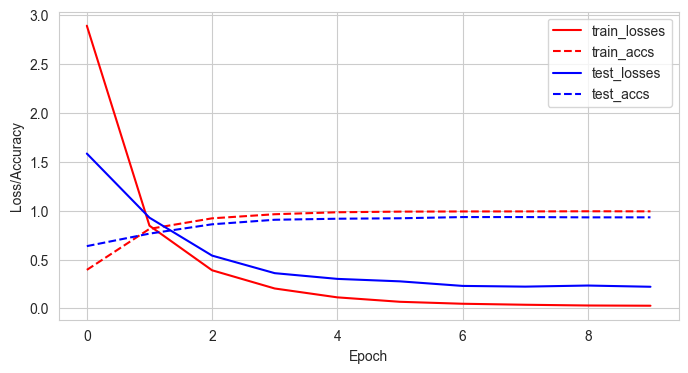

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, "r-", label="train_losses")
plt.plot(train_accs, "r--", label="train_accs")
plt.plot(test_losses, "b-", label="test_losses")
plt.plot(test_accs, "b--", label="test_accs")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# 加载最优模型

In [16]:
save_path = 'best_model.pth'  # 保存路径
# 重新定义模型（确保架构一致）
resnet = models.resnet18()
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)

# 加载训练好的权重
resnet.load_state_dict(torch.load(save_path,weights_only=True))

# 切换到 eval 模式
resnet.to(device)
resnet.eval()
print("模型已加载并设置为评估模式！")

模型已加载并设置为评估模式！


# 预测数据

In [17]:
resnet.eval()

# 单张图片预测
img_val_path = os.path.join(base_path,val_df['image'][0])
image_val = Image.open(img_val_path)
image_val_tensor = transform(image_val).unsqueeze(0)  # 应用转换 升维

# 预测
with torch.no_grad():
    image_val_tensor = image_val_tensor.to(device)
    output = resnet(image_val_tensor)
    probabilities = F.softmax(output, dim=1)  # 转换为概率
    pred_class = torch.argmax(probabilities).item()

print(torch.max(probabilities).item()*100,'%')
print(idx2label[pred_class])


96.79957032203674 %
asimina_triloba


In [18]:
# 批量预测

from LeaveDataset import LeaveValDataset

val_dataset = LeaveValDataset(val_df,transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print("val batch num:",len(val_loader))

val batch num: 69


In [19]:
all_preds = []

with torch.no_grad():
    for inputs in tqdm(val_loader):
        inputs = inputs.to(device)
        outputs = resnet(inputs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())

print("批量预测结果长度:", len(all_preds))

100%|██████████| 69/69 [00:27<00:00,  2.47it/s]

批量预测结果长度: 8800


In [20]:
pred_labels = [idx2label[pred_id] for pred_id in all_preds] # 转换成label
val_df['label'] = pred_labels
val_df.to_csv('submission.csv',index=False)
